In [2]:
# Import essential Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import TensorFlow and Keras modules for implementing the LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2025-02-18 22:09:35.258627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739905775.378304   63957 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739905775.410862   63957 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 22:09:35.700083: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def train_test_split_by_date(x, y, test_size=0.2):
    """
    Split the input data into training and test sets by date.
    The test set should contain the newest test_size proportion of the data.
    """
    df = pd.concat([x, y], axis=1)
    df = df.sort_values(by='author_date_unix_timestamp')
    split_index = int((1 - test_size) * len(df))
    x_train = df.iloc[:split_index, :-1]
    y_train = df.iloc[:split_index, -1]
    x_test = df.iloc[split_index:, :-1]
    y_test = df.iloc[split_index:, -1]
    return x_train, x_test, y_train, y_test


In [4]:
from sklearn.feature_selection import SelectFromModel
from mrmr import mrmr_classif

def select_features(x, y, method="model", estimator=None, threshold="median", 
                    correlation_threshold=0.9, num_features=50):
    """
    Select features using different methods.

    Parameters:
      - x: Training features (pandas DataFrame)
      - y: Training labels (pandas Series)
      - method: Which feature selection method to use.
                Options are:
                  "model" : Model-based feature selection using SelectFromModel.
                  "cbfs"  : Correlation-based feature selection (CBFS).
                  "mrmr"  : Minimum Redundancy Maximum Relevance (MRMR) using mrmr_selection.
      - estimator: (For "model" method) An estimator to compute feature importances.
                   If None, an XGBClassifier is used.
      - threshold: (For "model" method) The threshold for feature importance in SelectFromModel.
                   Default is "median".
      - correlation_threshold: (For "cbfs" method) Threshold to drop highly correlated features.
      - num_features: (For "mrmr" method) Number of features to select.
      
    Returns:
      - A list of selected feature names.
    """
    method = method.lower()
    if method == "model":
        if estimator is None:
            estimator = XGBClassifier(tree_method="hist", device="cuda", random_state=42)
        estimator.fit(x, y)
        selector = SelectFromModel(estimator, threshold=threshold, prefit=True)
        selected_features = list(x.columns[selector.get_support()])
        return selected_features

    elif method == "cbfs":
        # Compute the absolute correlation matrix and remove one of any pair of highly correlated features.
        corr_matrix = x.corr().abs()
        # Use only the upper triangle of the correlation matrix.
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
        selected_features = [col for col in x.columns if col not in to_drop]
        return selected_features

    elif method == "mrmr":
        # Call mrmr_classif directly with the DataFrame (not x.values) so that it can access the column names.
        selected_features = mrmr_classif(x, y, K=num_features)
        return selected_features

    else:
        raise ValueError("Method must be one of 'model', 'cbfs', or 'mrmr'")

In [5]:
# all columns in the dataset
INFO_COLUMNS = [
                "type", #"linked", "fileschanged",
                "ndev", "age", "exp", "rexp", "sexp",
                "glm_probability", "classification",
                "time_of_day", "day_of_week", "is_weekend",
                "author_experience", "author_ownership",
                "hash","file", "author_date_unix_timestamp"]

Y_COLUMN = ['contains_bug']

X_COLUMNS = ["d_cbo","d_cboModified","d_fanin",
             "d_fanout","d_wmc","d_dit","d_noc",
             "d_rfc","d_lcom","d_lcom*","d_tcc",
             "d_lcc","d_totalMethodsQty","d_staticMethodsQty",
             "d_publicMethodsQty","d_privateMethodsQty","d_protectedMethodsQty",
             "d_defaultMethodsQty","d_visibleMethodsQty","d_abstractMethodsQty",
             "d_finalMethodsQty","d_synchronizedMethodsQty","d_totalFieldsQty",
             "d_staticFieldsQty","d_publicFieldsQty","d_privateFieldsQty",
             "d_protectedFieldsQty","d_defaultFieldsQty","d_finalFieldsQty",
             "d_synchronizedFieldsQty","d_nosi","d_loc","d_returnQty","d_loopQty",
             "d_comparisonsQty","d_tryCatchQty","d_parenthesizedExpsQty","d_stringLiteralsQty",
             "d_numbersQty","d_assignmentsQty","d_mathOperationsQty","d_variablesQty",
             "d_maxNestedBlocksQty","d_anonymousClassesQty","d_innerClassesQty",
             "d_lambdasQty",
             #"d_uniqueWordsQty",
             "d_modifiers",
             #"d_logStatementsQty",
             "cbo","cboModified","fanin","fanout","wmc","dit","noc","rfc","lcom","lcom*",
             "tcc","lcc","totalMethodsQty","staticMethodsQty","publicMethodsQty",
             "privateMethodsQty","protectedMethodsQty","defaultMethodsQty",
             "visibleMethodsQty","abstractMethodsQty","finalMethodsQty",
             "synchronizedMethodsQty","totalFieldsQty","staticFieldsQty",
             "publicFieldsQty","privateFieldsQty","protectedFieldsQty",
             "defaultFieldsQty","finalFieldsQty","synchronizedFieldsQty",
             "nosi","loc","returnQty","loopQty","comparisonsQty",
             "tryCatchQty","parenthesizedExpsQty","stringLiteralsQty",
             "numbersQty","assignmentsQty","mathOperationsQty",
             "variablesQty","maxNestedBlocksQty","anonymousClassesQty",
             "innerClassesQty","lambdasQty",
             #"uniqueWordsQty", # Number of unique words in the source code
             "modifiers",
             #"logStatementsQty", # Number of log statements in the source code
             #"fix",
             "entrophy",
             "la","ld",
             #"net_lines_changed","absolute_lines_changed",
             "lines_per_file",
             "changed_file_count",
             #"entropy_bucket",
             ]

In [6]:
DATASETS = ["merged_datasets/new/broadleaf_merged_df.csv",
            "merged_datasets/new/camel_merged_df.csv",
            "merged_datasets/new/dubbo_merged_df.csv",
            "merged_datasets/new/elasticsearch_merged_df.csv",
            "merged_datasets/new/guava_merged_df.csv",
            "merged_datasets/new/jdk_merged_df.csv",
            "merged_datasets/new/jgroups_merged_df.csv",
            "merged_datasets/new/kafka_merged_df.csv",
            "merged_datasets/new/spark_merged_df.csv",
            "merged_datasets/new/spring-boot_merged_df.csv",
            "merged_datasets/new/spring-framework_merged_df.csv",
            "merged_datasets/new/tomcat_merged_df.csv",
            ]

In [8]:
# Function to create an LSTM model
def create_lstm_model(input_shape):

        # Initialize the LSTM model
    model = Sequential()

    # Add the first LSTM layer with Dropout regularization
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    # Add the second LSTM layer with Dropout regularization
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    # Add the third LSTM layer with Dropout regularization
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # Add the output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    """model = Sequential()
    # First LSTM layer with 64 units and returning sequences for stacking
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    # Second LSTM layer with 32 units (last LSTM layer need not return sequences)
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    # Final Dense layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])"""
    return model

In [9]:
def create_sliding_window(X, y, window_size):
    """
    Transform the data into sequences using a sliding window approach.
    
    Parameters:
      X (np.array): Array of features (already scaled).
      y (np.array): Array of target values.
      window_size (int): Number of consecutive rows in each window.
    
    Returns:
      X_seq (np.array): Array of sequences with shape (samples, window_size, features).
      y_seq (np.array): Array of labels corresponding to each sequence.
                         Here, the label for a window is the label of the last row.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size + 1):
        X_seq.append(X[i: i+window_size])
        y_seq.append(y[i+window_size-1])
    return np.array(X_seq), np.array(y_seq)

In [10]:
# import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
dataset_file = DATASETS[0]
df = pd.read_csv(dataset_file)

df = df.fillna(-1)

# Extract features and target. Make sure these columns exist in the CSV.
X = df[X_COLUMNS + INFO_COLUMNS]
y = df[Y_COLUMN]

# Split the dataset by date using the provided function
x_train, x_test, y_train, y_test = train_test_split_by_date(X, y, test_size=0.2)

# Perform feature selection on the training set using only X_COLUMNS
selected_features = select_features(x_train[X_COLUMNS], y_train,
                                            method="cbfs", correlation_threshold=0.5)
print(f"Selected features: {selected_features}")
print(len(selected_features))

# Scale the features (LSTM models often perform better with scaled inputs)
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train[selected_features])
x_test_scaled = scaler.transform(x_test[selected_features])

# Define the sliding window size (N)
window_size = 50  # You can adjust this value as needed

# Create sliding windows for both the training and test sets.
# The label for each window is taken as the label of the last row in that window.
x_train_seq, y_train_seq = create_sliding_window(x_train_scaled, y_train.to_numpy(), window_size)
x_test_seq, y_test_seq = create_sliding_window(x_test_scaled, y_test.to_numpy(), window_size)

# Build the LSTM model.
# The input shape now is (window_size, number_of_features)
input_shape = (x_train_seq.shape[1], x_train_seq.shape[2])
model = create_lstm_model(input_shape)

# Compile the model with both loss and accuracy metrics
"""model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])"""

from sklearn.utils.class_weight import compute_class_weight

# Get unique classes and compute weights
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(y_train_seq), 
                                     y=y_train_seq)

# Convert to a dictionary format required by Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

# Convert to a dictionary format required by Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


# Train the model
history = model.fit(x_train_seq, y_train_seq,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test_seq, y_test_seq),
                    class_weight=class_weight_dict)

# Evaluate the model
test_metrics = model.evaluate(x_test_seq, y_test_seq)
print(f'Test loss: {test_metrics[0]:.4f}, Test accuracy: {test_metrics[1]:.4f}')

Selected features: ['d_cbo', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'staticMethodsQty', 'privateMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'innerClassesQty', 'lambdasQty', 'modifiers', 'entrophy', 'la', 'lines_per_file']
34


I0000 00:00:1739905799.916255   63957 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Class Weights: {0: np.float64(0.79744252721932), 1: np.float64(1.3404985068448596)}
Epoch 1/10


2025-02-18 22:10:02.105364: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616583200 exceeds 10% of free system memory.
2025-02-18 22:10:02.632286: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616583200 exceeds 10% of free system memory.
I0000 00:00:1739905805.823777   64236 cuda_dnn.cc:529] Loaded cuDNN version 90300


2834/2834 ━━━━━━━━━━━━━━━━━━━━ 94s 32ms/step - accuracy: 0.7507 - loss: 0.1881 - val_accuracy: 0.7750 - val_loss: 0.1818
Epoch 2/10
2834/2834 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - accuracy: 0.7742 - loss: 0.1774 - val_accuracy: 0.7703 - val_loss: 0.1889
Epoch 3/10
2834/2834 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.7893 - loss: 0.1684 - val_accuracy: 0.7601 - val_loss: 0.1888
Epoch 4/10
2834/2834 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.7895 - loss: 0.1670 - val_accuracy: 0.7648 - val_loss: 0.1914
Epoch 5/10
2834/2834 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.7893 - loss: 0.1654 - val_accuracy: 0.7567 - val_loss: 0.1898
Epoch 6/10
2834/2834 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - accuracy: 0.7946 - loss: 0.1577 - val_accuracy: 0.7572 - val_loss: 0.1944
Epoch 7/10
2834/2834 ━━━━━━━━━━━━━━━━━━━━ 86s 30ms/step - accuracy: 0.7916 - loss: 0.1608 - val_accuracy: 0.7562 - val_loss: 0.1846
Epoch 8/10
2834/2834 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.7872 - loss: 0.16

In [13]:
# get classification report on the model
from sklearn.metrics import classification_report
import numpy as np

# Make predictions and convert to classes
y_pred_probs = model.predict(x_test_seq)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test_seq, y_pred))

708/708 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
              precision    recall  f1-score   support

       False       0.74      0.11      0.19      5949
        True       0.76      0.99      0.86     16683

    accuracy                           0.76     22632
   macro avg       0.75      0.55      0.52     22632
weighted avg       0.75      0.76      0.68     22632



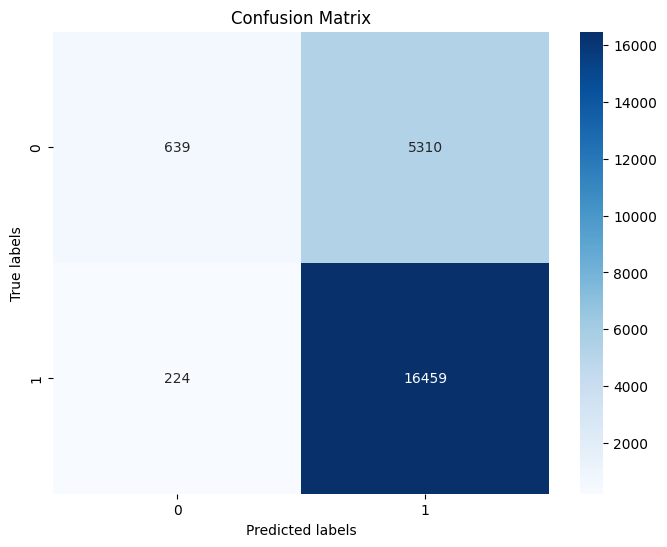

In [14]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


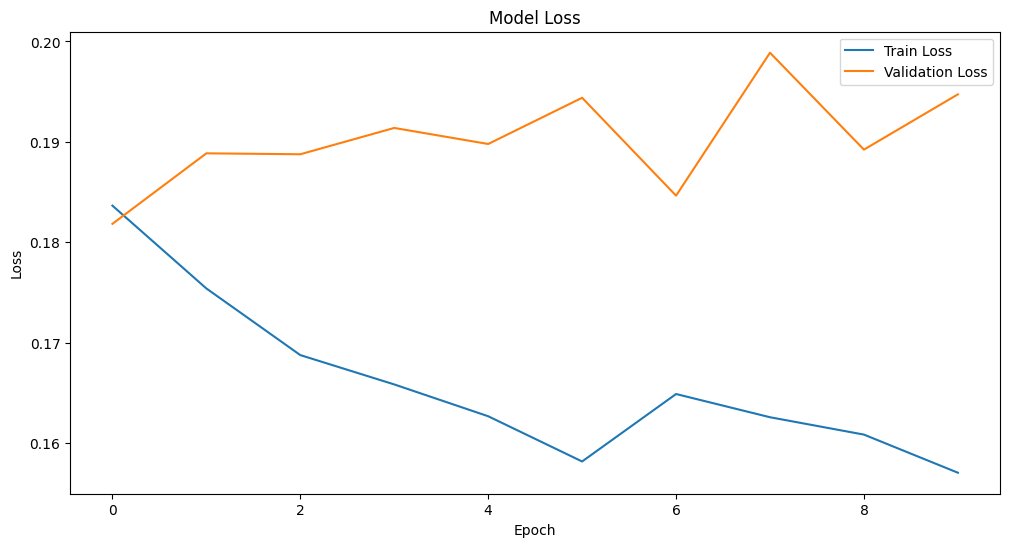

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()